In [5]:
import glob
import os
import pandas as pd
import numpy as np
import time

## Prepare Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Machine learning model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report


# working with uneven data sets
from imblearn.over_sampling import SMOTE

# ROC
from sklearn.metrics import roc_curve, auc

## Metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

## plot graphs
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

In [6]:
### Functions

files_relative_path = 'data2/'

file_name = 'IDS.csv'
files_names = ['LDAP.csv', 'MSSQL.csv', 'NetBIOS.csv', 'Portmap.csv', 'Syn.csv', 'UDP.csv', 'UDPLag.csv']


def load_dataset(file_path, file_name, nrows=10000000):
    full_path = os.path.join(file_path, file_name)
    data_set = pd.read_csv(full_path, header=0, nrows=nrows, dtype={'Column85': str}, low_memory=False)
    
    data_set.columns = data_set.columns.str.strip()
    
    return data_set

def get_samples_by_label(data_frame, label):
    data_frame.columns = data_frame.columns.str.strip()
    
    filtered_samples = data_frame[data_frame["Label"] == label]
    
    return filtered_samples

def combine_datasets(file_path, file_names, nrows=15000):
    
    dataframes = []
    
    for name in file_names:
        try:
            df = load_dataset(file_path, name, nrows)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {os.path.join(file_path, name)}: {e}")
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.columns = combined_df.columns.str.strip()
    
    return combined_df


def calculate_label_distribution(dataframe, label_column):
    total_samples = dataframe.shape[0]
    label_counts = dataframe[label_column].value_counts()
    
    distribution = {}
    for label, count in label_counts.items():
        percentage = (count / total_samples) * 100
        distribution[label] = {
            'count': count,
            'percentage': percentage
        }
        
    return distribution

def display_label_distribution(label_distribution):
    for label, stats in label_distribution.items():
        print(f"Samples Count: {label}: {stats['count']}")
        print(f"Percentage distribution of data: {label}: {stats['percentage']:.2f}%")
    

def display_unique_labels(data_frame):
    unique_labels = data_frame["Label"].unique()
    print("Unique Labels:", unique_labels)

def display_dataset_length(data_frame):
    length = len(data_frame)
    print("Dataset length:", length)

In [7]:

def visualize_nulls(data_frame):
    null_counts = data_frame.isna().sum()
    total_rows = len(data_frame)
    
    # Filtrujemy kolumny z wartościami null
    null_counts = null_counts[null_counts > 0]
    
    # Sprawdzenie, czy są jakiekolwiek wartości null
    if null_counts.empty:
        print("No null value in the dataset.")
        return

    # Liczba kolumn z wartościami null
    num_null_columns = (null_counts > 0).sum()
    print(f"Liczba kolumn z wartościami null: {num_null_columns}")
    
    # Obliczamy procentowe udziały
    null_percentage = (null_counts / total_rows) * 100
    
    # Tworzymy DataFrame do wizualizacji
    null_summary = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage': null_percentage
    })
    
    # Wizualizacja
    plt.figure(figsize=(12, 6))
    null_summary['Null Count'].plot(kind='bar', color='skyblue', alpha=0.7, label='Liczba Nulli')
    plt.ylabel('Number of Null')
    
    # Dodanie drugiej osi dla procentów
    ax2 = plt.gca().twinx()
    null_summary['Null Percentage'].plot(kind='line', marker='o', color='orange', ax=ax2, label='Procent Nulli')
    ax2.set_ylabel('Procent Nulli (%)')
    
    plt.title('Number and Percentage of Null Values in Features')
    plt.xticks(rotation=45)
    
    # Legenda
    plt.legend(loc='upper left')
    
    plt.show()

def visualize_labels(data_frame):
    # Zliczanie próbek dla każdej etykiety
    label_counts = data_frame['Label'].value_counts()

    # Ustawienie stylu wykresu
    sns.set(style="whitegrid")

    # Tworzenie wykresu słupkowego
    plt.figure(figsize=(10, 6))
    
    # Użycie hue dla poprawnej wizualizacji
    ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, legend=False)

    # Dodawanie etykiet do słupków
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)

    # Dodawanie tytułu i etykiet osi
    plt.title('Distribution of samples', fontsize=16)
    plt.xlabel('Attack type', fontsize=14)
    plt.ylabel('Number of Cases', fontsize=14)
    
    # Ustawienie osi X na poziomie 0.5 dla lepszej czytelności
    plt.xticks(rotation=45)
    
    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()

In [55]:
combined_df = combine_datasets(files_relative_path, files_names, nrows=25000)

display_unique_labels(combined_df)
display_dataset_length(combined_df)

label_distribution = calculate_label_distribution(combined_df, 'Label')

display_label_distribution(label_distribution)

Unique Labels: ['NetBIOS' 'BENIGN' 'LDAP' 'MSSQL' 'Portmap' 'Syn' 'UDP']
Dataset length: 175000
Samples Count: NetBIOS: 49955
Percentage distribution of data: NetBIOS: 28.55%
Samples Count: MSSQL: 38679
Percentage distribution of data: MSSQL: 22.10%
Samples Count: Syn: 25000
Percentage distribution of data: Syn: 14.29%
Samples Count: UDP: 24998
Percentage distribution of data: UDP: 14.28%
Samples Count: Portmap: 20285
Percentage distribution of data: Portmap: 11.59%
Samples Count: LDAP: 9931
Percentage distribution of data: LDAP: 5.67%
Samples Count: BENIGN: 6152
Percentage distribution of data: BENIGN: 3.52%


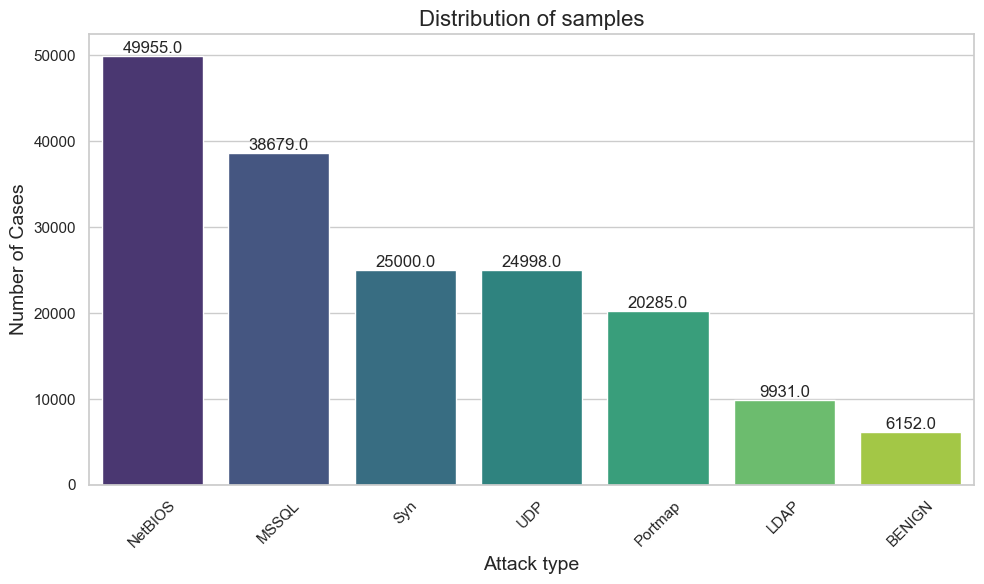

In [56]:
visualize_labels(combined_df)

In [10]:
# first_dataset = load_dataset(files_relative_path, file_name)

# ## Adding “non-malignant” samples from another dataset to even out the ratio
# benign_samples = get_samples_by_label(first_dataset, "BENIGN")

# new_combined_df = pd.concat([combined_df, benign_samples], ignore_index=True)

# display_dataset_length(new_combined_df)
# label_distribution = calculate_label_distribution(new_combined_df, 'Label')
# display_label_distribution(label_distribution)

# print(f"Beningn samples length: {len(benign_samples)}")

Drops and Renames
Some columns are not intended for use because they are metadata. Flow ID, IP addresses, timestamps, etc.

If you are unsure why source and destination port are also removed you can read Establishing the Contaminating Effect of Metadata Feature Inclusion in Machine-Learned Network Intrusion Detection Models.. In short: any included metadata feature will act as a (very) powerful shortcut predictor.

Metadata features
Metadata features are information that is not directly related to the problem being analyzed, but may contain relevant contextual data. In the case of DDoS attack detection, such features may include:
Flow ID: a unique identifier for each network flow.
IP addresses: source and destination IP addresses can be used to identify attackers or victims.
Timestamps: timestamps can help identify when an attack took place.
Contamination of the model
Incorporating these features into a model can lead to what is known as model contamination, meaning that the model can learn to rely on these easy-to-predict features instead of the more complex patterns associated with DDoS attacks.

For example:
The model may learn that certain IP addresses are always associated with attacks, which can lead to erroneous conclusions for new, unfamiliar addresses.
Conclusion
The author suggests that removing such metadata features from training data can improve the quality of the model. This will force the model to focus on more relevant features related to attacks, which should improve its ability to generalize and be effective in detecting real attacks.
Agree with the hint
I agree with this approach. In the context of DDoS attack detection:
Complexity of the problem: Models should be trained on features that actually reflect the behavior of attacks, rather than on simple metadata indicators.
Generalization: Removing metadata features helps create models that better rad

In [57]:
drop_columns = [
    "Flow ID",  
    'Fwd Header Length.1',
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Unnamed: 0", "Inbound", "SimillarHTTP"
]

combined_df = combined_df.drop(columns=drop_columns, errors='ignore', axis=1)

# Verify removal columns
len(combined_df.columns)

78

# Data Preprocessing

Dropping duplicates
There should be no duplicates because they can bias training and can lead
to over-optimistic estimates of classification performance during testing.

In [58]:
def delete_duplicates(data):
    print(data.duplicated().sum(), "fully duplicate rows to remove")   
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)  
    print(data.shape)
    return data

combined_df = delete_duplicates(combined_df)

display_dataset_length(combined_df)

135722 fully duplicate rows to remove
(39278, 78)
Dataset length: 39278


In [59]:
def remove_missing_values(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    print(df.isna().any(axis=1).sum(), "rows with at least one NaN to remove")
    df.dropna(inplace=True) 

    return df

def imputation_missing_values(df):
    # Converting inf to NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

     # Imputation of missing values for number type features (example: use of median)
    for column in df.select_dtypes(include=[np.number]).columns:
            median_value = df[column].median()
            df[column] = df[column].fillna(median_value)
   
    return df 

# processed_dataset = imputation_missing_values(combined_df)
processed_dataset = remove_missing_values(combined_df)
display_dataset_length(processed_dataset)

857 rows with at least one NaN to remove
Dataset length: 38421


In [60]:
def check_none_numerican_columns(data_frame):
    object_columns = data_frame.select_dtypes(include=['object']).columns
    
    if not object_columns.empty:
        print("Columns with type object:", object_columns)
    else:
       print("DataSet does not have any columns with values: Nan")

    return

check_none_numerican_columns(processed_dataset)

Columns with type object: Index(['Label'], dtype='object')


In [15]:
# def remove_high_missing_columns(data_frame, threshold=0.3):
#     # Obliczamy próg brakujących wartości
#     missing_percentage = data_frame.isnull().mean()
    
#     # Identyfikujemy kolumny do usunięcia
#     columns_to_remove = missing_percentage[missing_percentage >= threshold].index.tolist()
    
#     # Usuwamy kolumny
#     data_frame_cleaned = data_frame.drop(columns=columns_to_remove)
    
#     # Usuwamy wiersze, które mają NaN w pozostałych kolumnach
#     data_frame_cleaned.dropna(inplace=True)
    
#     print(f"Deleted columns: {columns_to_remove}")
    
#     return data_frame_cleaned

# cleaned_df = remove_high_missing_columns(new_data_set, threshold=0.4)

In [16]:
# def replace_missing_columns_most_common_value(data_frame, threshold=0.3):
#     # Obliczamy próg brakujących wartości
#     missing_percentage = data_frame.isnull().mean()
    
#     # Identyfikujemy kolumny z dużą ilością NaN
#     columns_to_replace = missing_percentage[missing_percentage >= threshold].index.tolist()
    
#     for column in columns_to_replace:
#         # Zastępujemy NaN najczęściej występującą wartością
#         most_frequent_value = data_frame[column].mode()[0]  # Pobieramy najczęściej występującą wartość

#         most_frequent_count = data_frame[column].value_counts().iloc[0]  # Liczba wystąpień najczęstszej wartości
                
#         print(f"Most frequent value - {most_frequent_value} for column - {column} with count - {most_frequent_count}")
#         data_frame[column] = data_frame[column].fillna(most_frequent_value)  # Zastępujemy NaN
        
#     print(f"Replaced NaN values in columns: {columns_to_replace}")
    
#     return data_frame

In [17]:
# clear_data_set = replace_missing_columns_most_common_value(processed_dataset, threshold=0.4)
# visualize_nulls(clear_data_set)

In [61]:
label_distribution = calculate_label_distribution(processed_dataset, 'Label')
display_label_distribution(label_distribution)

Samples Count: UDP: 12602
Percentage distribution of data: UDP: 32.80%
Samples Count: Syn: 10223
Percentage distribution of data: Syn: 26.61%
Samples Count: MSSQL: 7705
Percentage distribution of data: MSSQL: 20.05%
Samples Count: BENIGN: 5721
Percentage distribution of data: BENIGN: 14.89%
Samples Count: Portmap: 859
Percentage distribution of data: Portmap: 2.24%
Samples Count: NetBIOS: 735
Percentage distribution of data: NetBIOS: 1.91%
Samples Count: LDAP: 576
Percentage distribution of data: LDAP: 1.50%


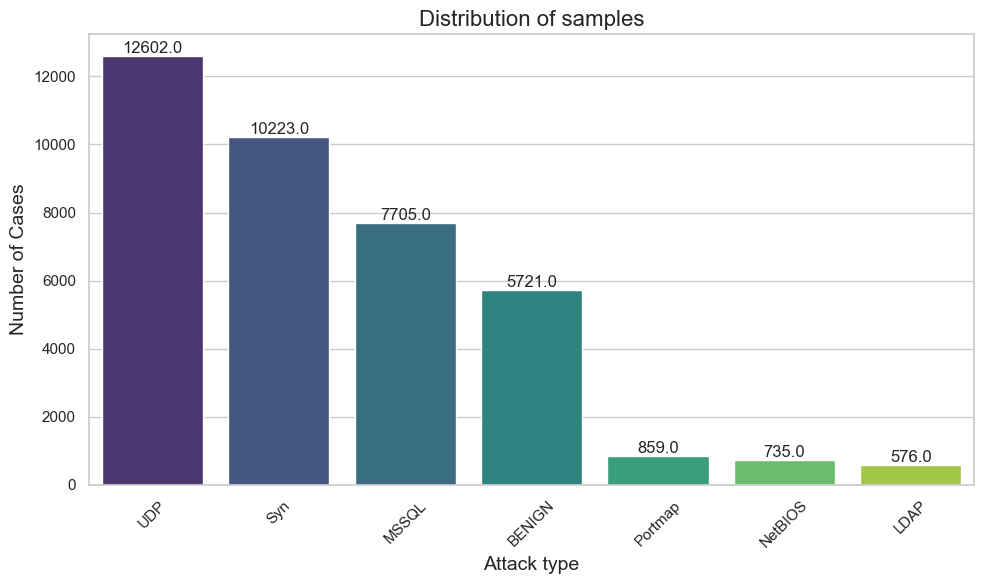

In [62]:
 visualize_labels(processed_dataset)

In [63]:
def map_label(df):
    # Mapping labels to numerical values
    label_mapping = {
        "BENIGN": 0,
        "NetBIOS": 1,
        "LDAP": 2,
        "MSSQL": 3,
        "Portmap": 4,
        "Syn": 5,
        "UDP": 6
    }
    df['Label'] = df['Label'].map(label_mapping)
    return df

In [64]:
mapped_df = map_label(processed_dataset.copy())
print(mapped_df['Label'].unique())

[1 0 2 3 4 5 6]


In [65]:
label_distribution = calculate_label_distribution(mapped_df, 'Label')
display_label_distribution(label_distribution)

Samples Count: 6: 12602
Percentage distribution of data: 6: 32.80%
Samples Count: 5: 10223
Percentage distribution of data: 5: 26.61%
Samples Count: 3: 7705
Percentage distribution of data: 3: 20.05%
Samples Count: 0: 5721
Percentage distribution of data: 0: 14.89%
Samples Count: 4: 859
Percentage distribution of data: 4: 2.24%
Samples Count: 1: 735
Percentage distribution of data: 1: 1.91%
Samples Count: 2: 576
Percentage distribution of data: 2: 1.50%


# Visualization Data

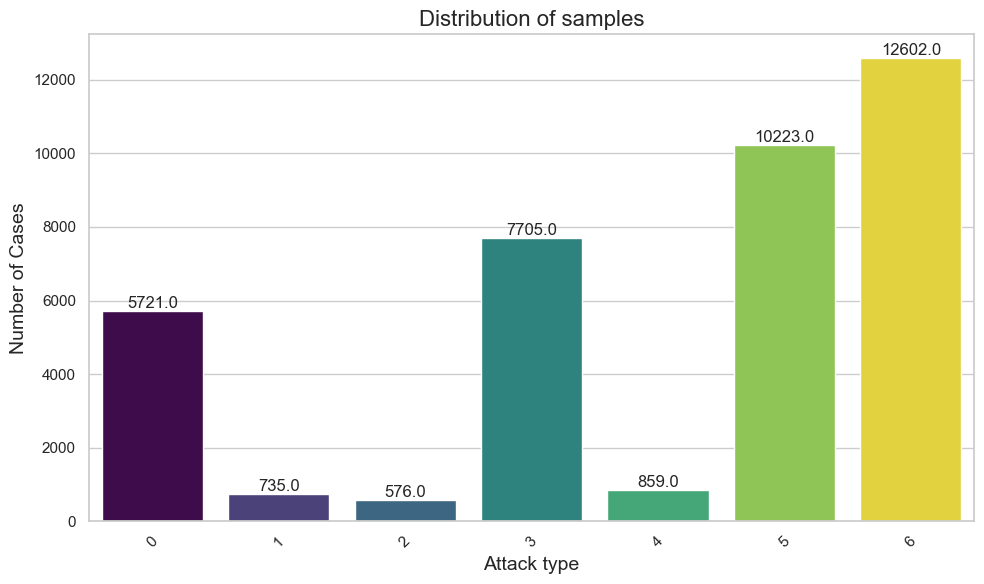

In [66]:
visualize_labels(mapped_df)

In [67]:
# Make sure the labels are properly coded as categories. 
label_encoder = LabelEncoder()
mapped_df['Label'] = label_encoder.fit_transform(mapped_df['Label'])

# Data splitting into training and test

In [68]:
## Feature and Target variable
X = mapped_df.drop('Label', axis=1)
Y = mapped_df['Label']


## Convert to numPy array
x1 = np.array(X).astype(np.float64)
y1 = np.array(Y)

## Always check dataset length
assert len(X) == len(Y), "The lengths of feature sets and labels do not match."

In [69]:
## Split data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## Check
train_persent = len(X_train) / len(mapped_df) * 100
test_percent = len(X_test) / len(mapped_df) * 100

print("Train", train_persent)
print("Test", test_percent)

Train 69.99817807969599
Test 30.001821920304


In [70]:
def generate_smoth_samples(X_train, Y_train):
        # Initalize SMOTE
        smote = SMOTE(random_state=42)
    
        # Generate new samples
        X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)
    
        # Check the distribution of classes after applying SMOTE
        print("Class distribution after application of SMOTE:")
        print(pd.Series(y_resampled).value_counts())

        return X_resampled, y_resampled
    
X_resampled, y_resampled = generate_smoth_samples(X_train, Y_train)

Class distribution after application of SMOTE:
Label
5    8816
6    8816
3    8816
0    8816
1    8816
4    8816
2    8816
Name: count, dtype: int64


In [71]:
def time_execution(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"time execution: {execution_time:.4f} minut")
    
    return result

# Training Model

## I model - Random Forest


Algorytmy do rozważenia
Oprócz Random Forest, istnieje wiele innych algorytmów, które są znane jako dobre klasyfikatory wieloklasowe:

- Gradient Boosting Machines (GBM): Algorytmy takie jak XGBoost, LightGBM czy CatBoost są bardzo popularne w zadaniach klasyfikacyjnych i często osiągają lepsze wyniki niż tradycyjne metody.
  
- Support Vector Machines (SVM): SVM mogą być używane z różnymi jądrami do klasyfikacji wieloklasowej.

- K-nearest neighbors (KNN): Prosty, ale skuteczny algorytm, który działa dobrze w przypadku małych zbiorów danych.
  
- Neural Networks: Sieci neuronowe, zwłaszcza w kontekście głębokiego uczenia, mogą być bardzo skuteczne w klasyfikacji wieloklasowej.
  
- Naive Bayes: Dobry wybór dla problemów z dużą liczbą cech, zwłaszcza gdy dane są rozkładane normalnie.

In [72]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
time_execution(rf_model.fit, X_resampled, y_resampled)
rf_pred = rf_model.predict(X_test)
rf_pred

time execution: 0.0469 minut


array([0, 5, 6, ..., 0, 5, 5])

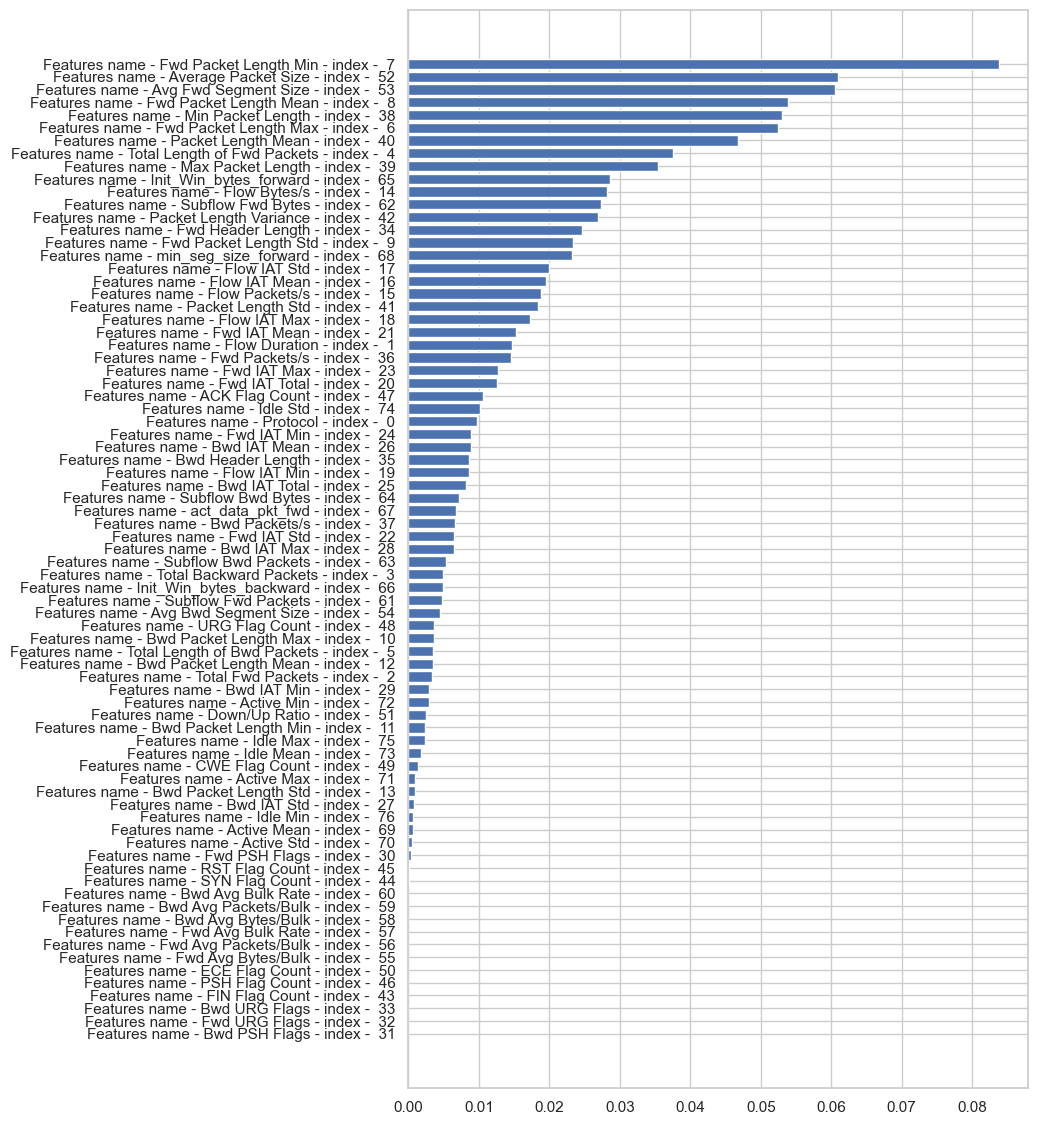

In [73]:
## importances feature from the model
def show_importances_feature(model):
    importances = model.feature_importances_

    ## sorted by importance
    indexes = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
    feature_column_names = [f"Features name - {mapped_df.columns[i]} - index -  {i}" for i in indexes]
    
    plt.figure(figsize=(8, 14))
    plt.barh(range(X_train.shape[1]), importances[indexes], align="center")
    plt.yticks(range(X_train.shape[1]), feature_column_names)
    plt.show()

show_importances_feature(rf_model)

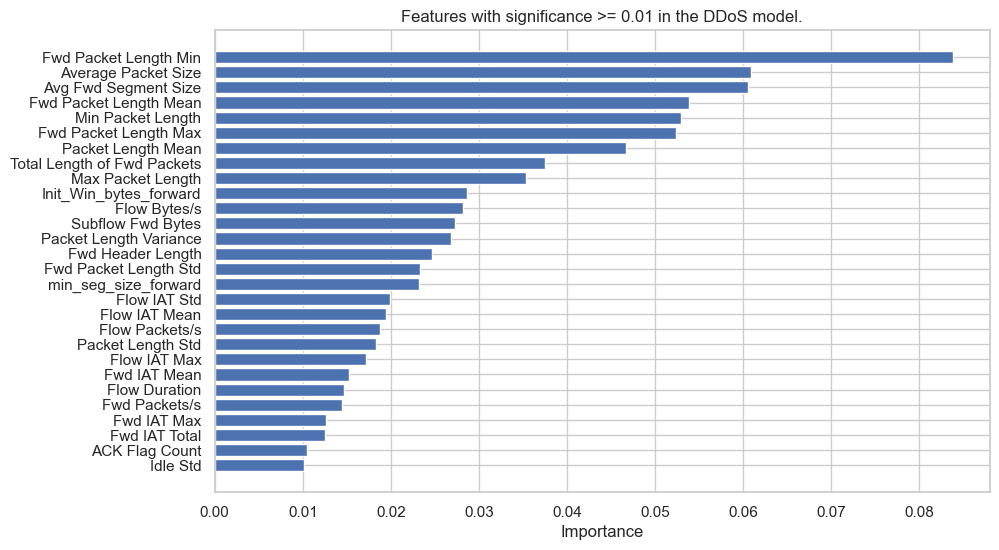

In [74]:
def extract_important_features(model, mapped_df, threshold=0.010):
    # Importances feature from the model
    importances = model.feature_importances_
    
    # Get the indices of features that meet the threshold
    indices = np.where(importances >= threshold)[0]  # Get indices of features with importance >= threshold
    
    # If no features meet the threshold, return a message
    if len(indices) == 0:
        print("No features with significance >= {}.".format(threshold))
        return

    # Get feature names and importances of the selected features
    important_feature_names = [mapped_df.columns[i] for i in indices]
    important_importances = importances[indices]

    # Sort features by importance in descending order
    sorted_indices = np.argsort(important_importances)
    sorted_feature_names = [important_feature_names[i] for i in sorted_indices]
    sorted_importances = important_importances[sorted_indices]
    
    # Create a horizontal bar plot for the important features
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_importances, align='center')
    plt.xlabel('Importance')
    plt.title('Features with significance >= {} in the DDoS model.'.format(threshold))
    plt.show()

    return indices

# Wywołanie funkcji z modelem rf_model
important_features_indices = extract_important_features(rf_model, mapped_df)

Wybór istotnych cech w modelu DDoS
Aby określić, które cechy są istotne dla modelu detekcji ataków DDoS, warto przyjąć pewien próg dla wartości ważności cech. W przypadku modeli opartych na drzewach decyzyjnych, takich jak Random Forest, można wykorzystać wartości ważności cech (feature importances) do oceny ich wpływu na model.

- Próg 0.05 (5%):
Cechy o ważności powyżej 5% są zazwyczaj uznawane za istotne. Ten próg jest często stosowany w praktyce i może pomóc w redukcji liczby cech do tych, które mają bardziej znaczący wpływ na wyniki modelu.

- Próg 0.1 (10%):
Cechy o ważności powyżej 10% są zdecydowanie istotne i powinny być brane pod uwagę w kolejnych iteracjach modelowania. Umożliwia to skoncentrowanie się na tych cechach, które mają największy wpływ na wydajność modelu.


- Próg 0.2 (20%):
Cechy o ważności powyżej 20% mogą być uznawane za kluczowe dla modelu. Wybór tylko tych cech może prowadzić do uproszczenia modelu i poprawy interpretowalności

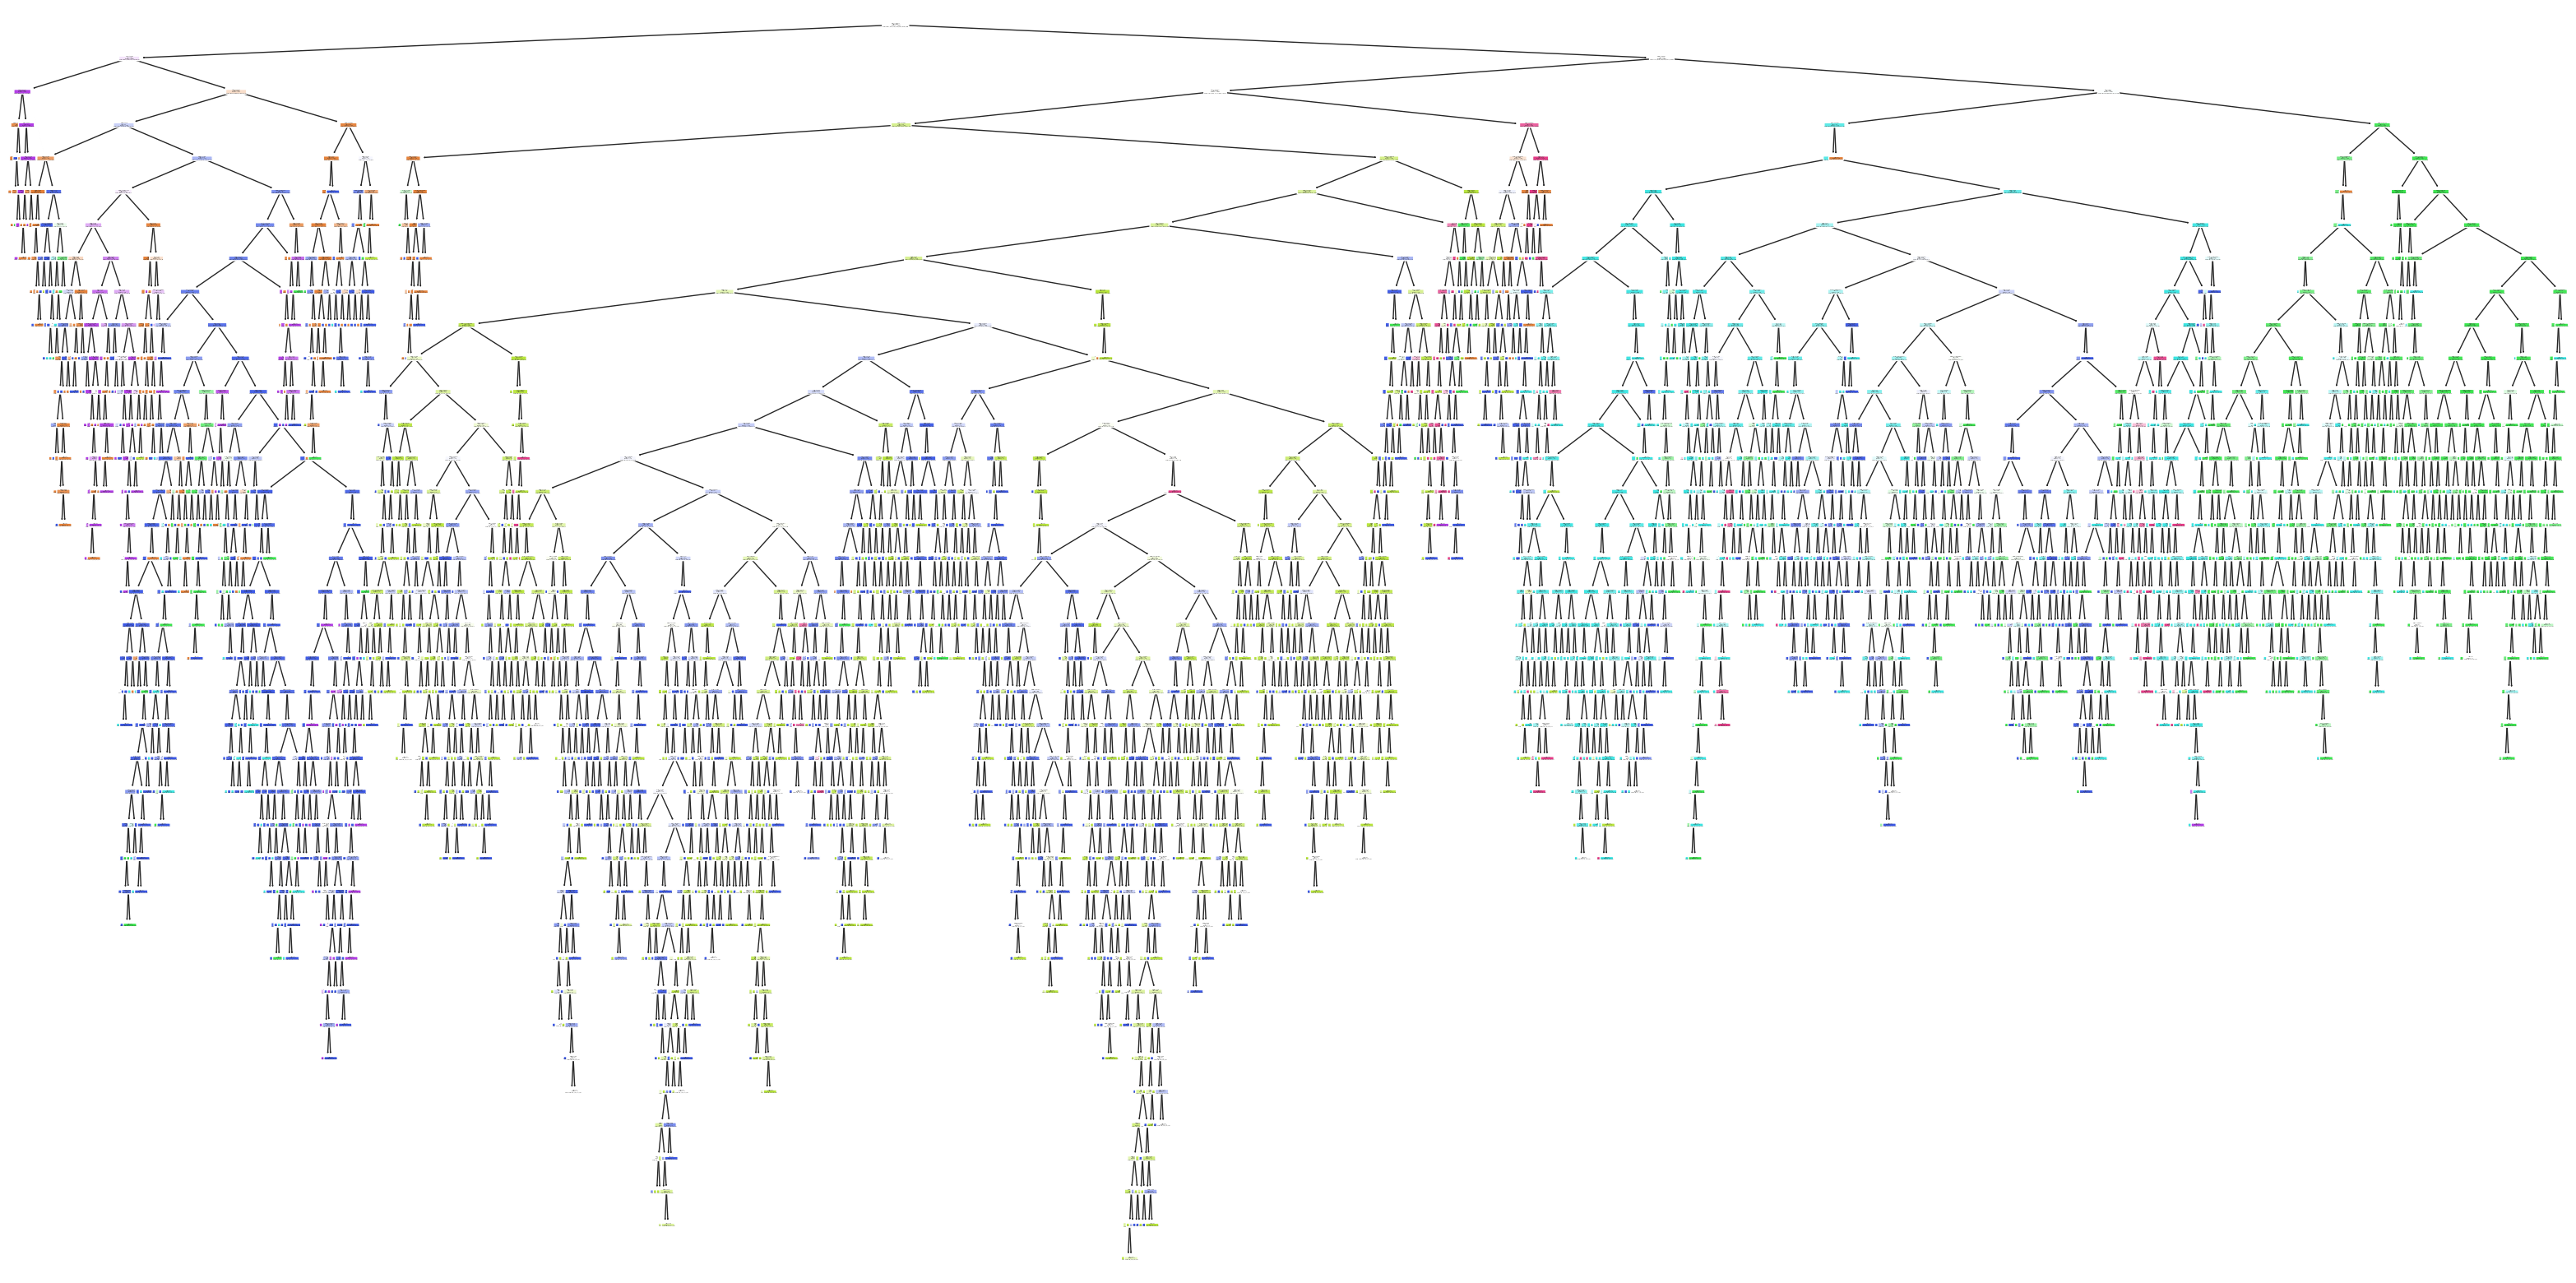

In [79]:
from sklearn.tree import plot_tree

estimator = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, rounded=True)

plt.show()

# Model Evaluation

In [76]:
 ## Generate and display a detailed confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [80]:
def visualizationMetrics(accuracy, f1, precision, recall):
   metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Value': [accuracy, f1, precision, recall]
    }

   df_metrics = pd.DataFrame(metrics_data)

   print(df_metrics)

In [81]:
rf_accuracy = accuracy_score(Y_test, rf_pred)
# rf_f1 = f1_score(Y_test, rf_pred)
# rf_precision = precision_score(Y_test, rf_pred)
# rf_recall = recall_score(Y_test, rf_pred)

# Użycie 'macro' jako przykład
rf_f1 = f1_score(Y_test, rf_pred, average='macro')
rf_precision = precision_score(Y_test, rf_pred, average='macro')
rf_recall = recall_score(Y_test, rf_pred, average='macro')

visualizationMetrics(rf_accuracy, rf_f1, rf_precision, rf_recall)

      Metric     Value
0   Accuracy  0.974842
1   F1 Score  0.879065
2  Precision  0.869852
3     Recall  0.889647


### Visualization

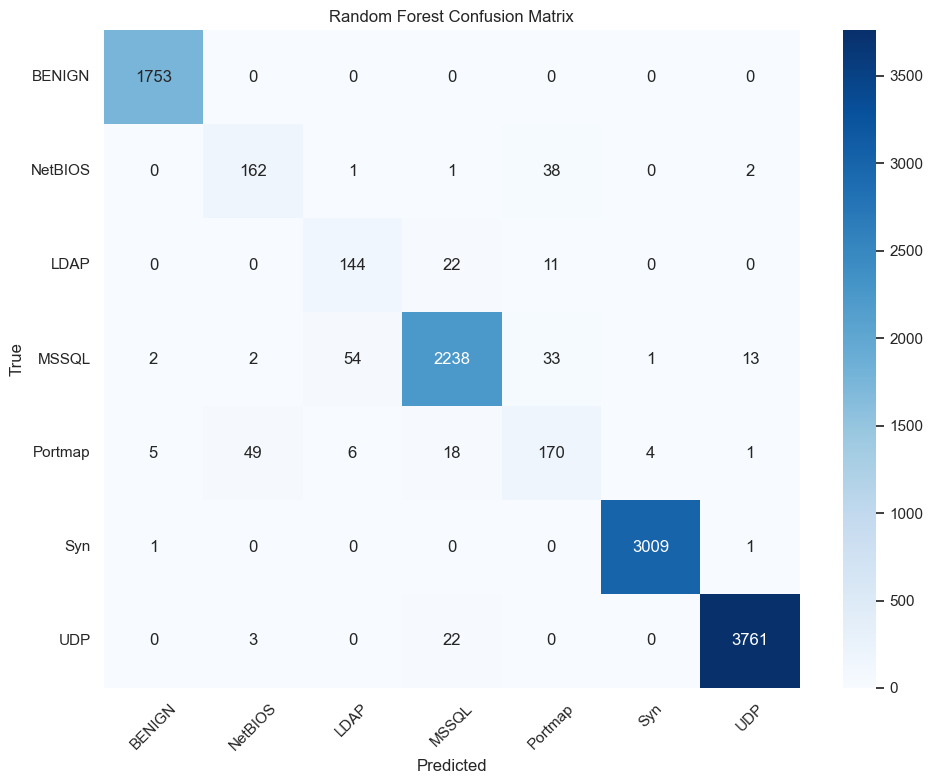

In [82]:
classes = ['BENIGN', 'NetBIOS', 'LDAP', 'MSSQL', 'Portmap', 'Syn', 'UDP']

plot_confusion_matrix(Y_test, rf_pred, classes, "Random Forest Confusion Matrix")

### SVC - Support Vector Machine

In [59]:
svm_model = SVC(kernel='rbf', random_state=42)
time_execution(svm_model.fit, X_resampled, y_resampled)
y_pred = svm_model.predict(X_test)
y_pred

time execution: 26.0877 minut


array([6, 6, 6, ..., 5, 6, 6])

In [63]:
svm_accuracy = accuracy_score(Y_test, y_pred)

# Użycie 'macro' jako przykład
svm_f1 = f1_score(Y_test, y_pred, average='macro')
svm_precision = precision_score(Y_test, y_pred, average='macro')
svm_recall = recall_score(Y_test, y_pred, average='macro')

visualizationMetrics(svm_accuracy, svm_f1, svm_precision, svm_recall)

      Metric     Value
0   Accuracy  0.754761
1   F1 Score  0.418002
2  Precision  0.510318
3     Recall  0.462384


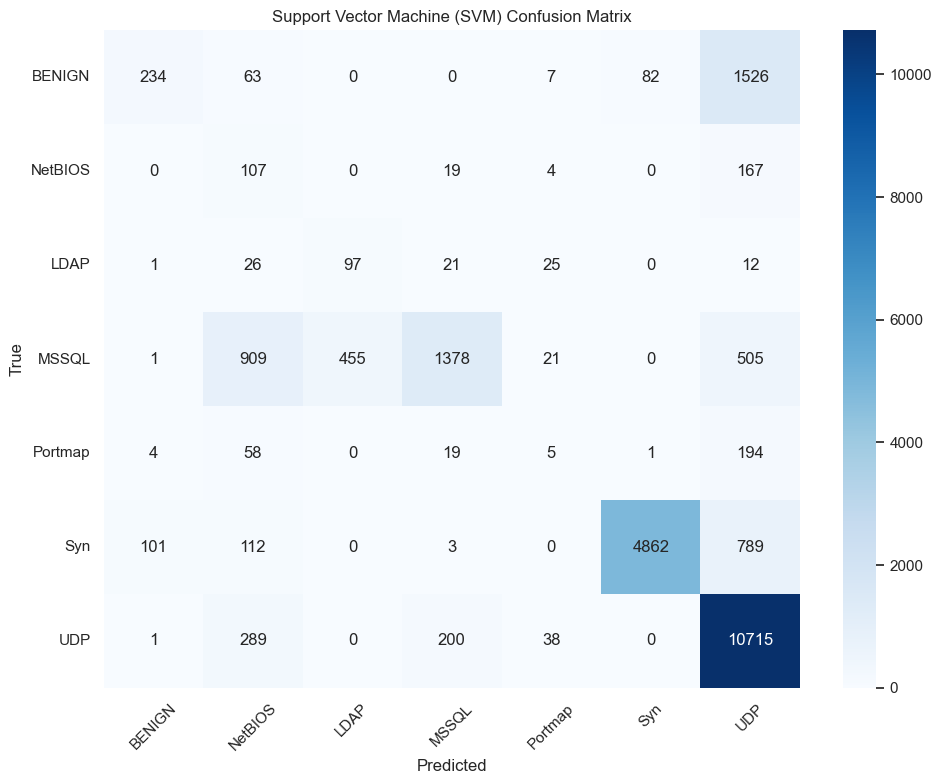

In [92]:
plot_confusion_matrix(Y_test, y_pred, classes, "Support Vector Machine (SVM) Confusion Matrix")

### Neural Network

In [108]:
nn_model = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, random_state=42)

time_execution(nn_model.fit, X_train, Y_train)
nn_pred = nn_model.predict(X_test)

time execution: 0.4699 minut


In [111]:
nn_accuracy = accuracy_score(Y_test, nn_pred)
nn_f1 = f1_score(Y_test, nn_pred, average='macro')
nn_precision = precision_score(Y_test, nn_pred, average='macro')
nn_recall = recall_score(Y_test, nn_pred, average='macro')


print(f"Accuracy: {nn_accuracy:.4f}")
print(f"F1 Score: {nn_f1:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")

Accuracy: 0.9428
F1 Score: 0.7794
Precision: 0.7703
Recall: 0.7939


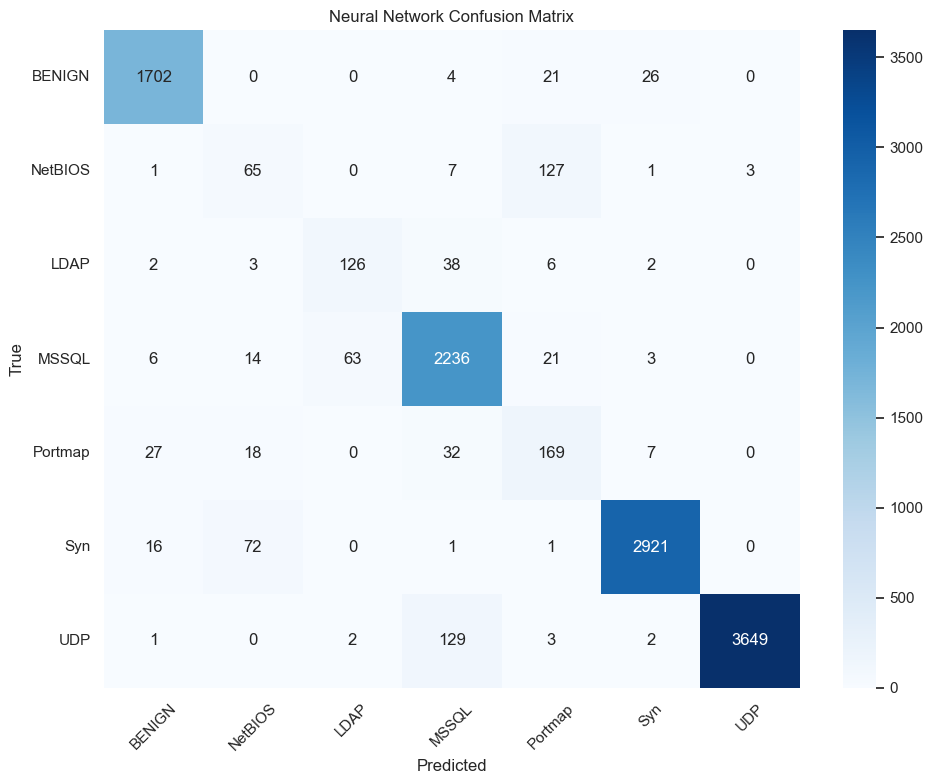

In [112]:
plot_confusion_matrix(Y_test, nn_pred, classes, "Neural Network Confusion Matrix")

# Re-learning

In [47]:
def trim_datataset(mapped_df, important_features_indices):
    # Create a new DataFrame with only important features
    trimmed_df = mapped_df.iloc[:, important_features_indices].copy()  # Keep only important features
    trimmed_df['Label'] = mapped_df['Label']  # Ensure to keep the label column
    
    return trimmed_df

trimmed_dataset = trim_datataset(mapped_df, important_features_indices)
len(trimmed_dataset)

150752

In [48]:
## Feature and Target variable
re_X = trimmed_dataset.drop('Label', axis=1)
re_Y = trimmed_dataset['Label']


## Convert to numPy array
re_x1 = np.array(X).astype(np.float64)
re_y1 = np.array(Y)

## Always check dataset length
assert len(re_X) == len(re_Y), "The lengths of feature sets and labels do not match."

In [49]:
## Split data into training and testing set
re_X_train, re_X_test, re_Y_train, re_Y_test = train_test_split(re_X, re_Y, test_size=0.30, random_state=42)

## Check
re_train_persent = len(re_X_train) / len(trimmed_dataset) * 100
re_test_percent = len(re_X_test) / len(trimmed_dataset) * 100

print("Train", re_train_persent)
print("Test", re_test_percent)

Train 69.99973466355338
Test 30.000265336446613


In [50]:
re_X_resampled, re_y_resampled = generate_smoth_samples(re_X_train, re_Y_train)

Class distribution after application of SMOTE:
Label
6    59476
0    59476
3    59476
5    59476
4    59476
2    59476
1    59476
Name: count, dtype: int64


In [51]:
re_rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
time_execution(rf_model.fit, re_X_resampled, re_y_resampled)
re_rf_pred = rf_model.predict(re_X_test)
re_rf_pred

time execution: 0.5073 minut


array([6, 6, 5, ..., 5, 5, 6])

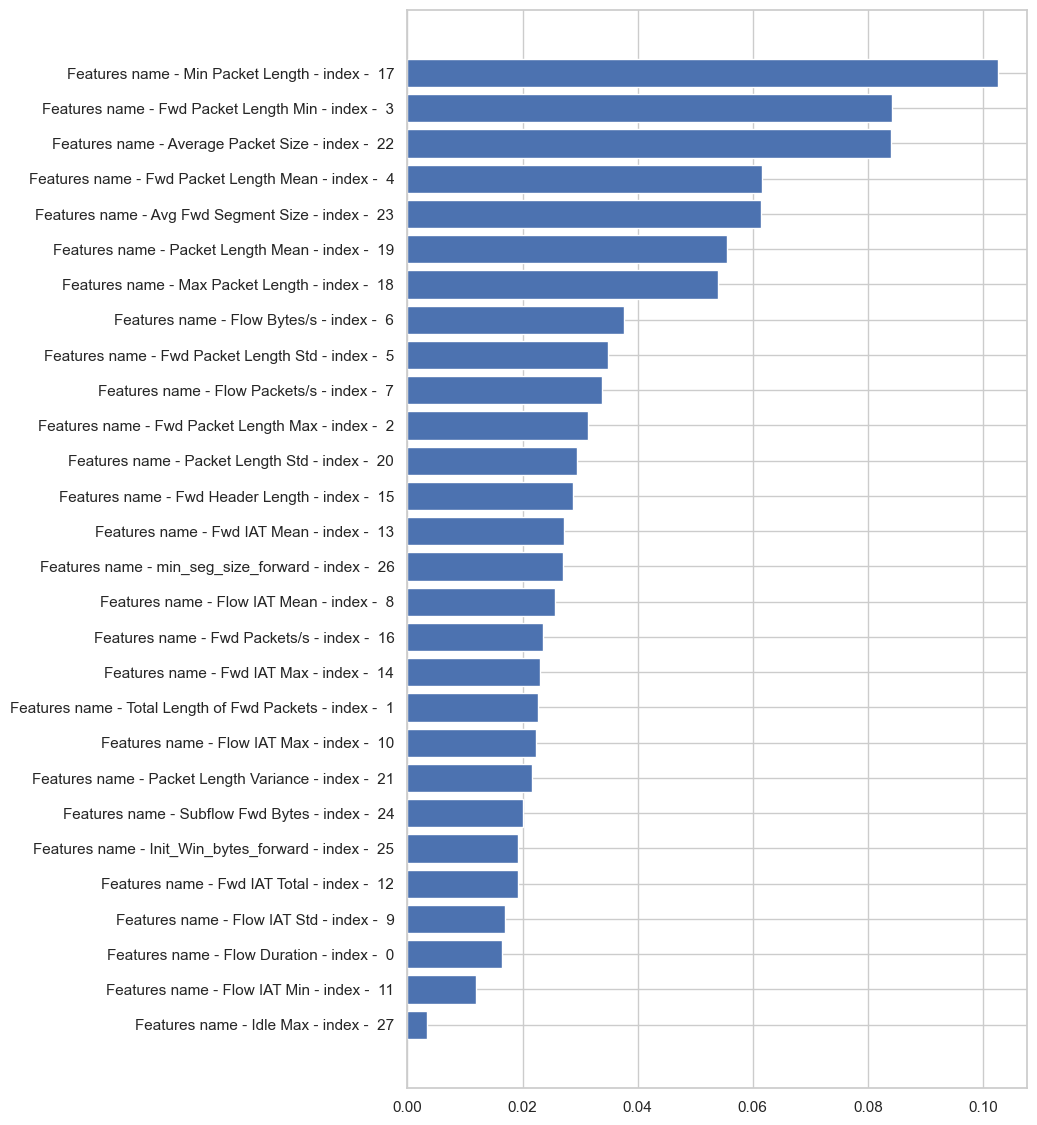

In [52]:
importances = rf_model.feature_importances_

indexes = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
feature_column_names = [f"Features name - {trimmed_dataset.columns[i]} - index -  {i}" for i in indexes]

plt.figure(figsize=(8, 14))
plt.barh(range(re_X_train.shape[1]), importances[indexes], align="center")
plt.yticks(range(re_X_train.shape[1]), feature_column_names)
plt.show()

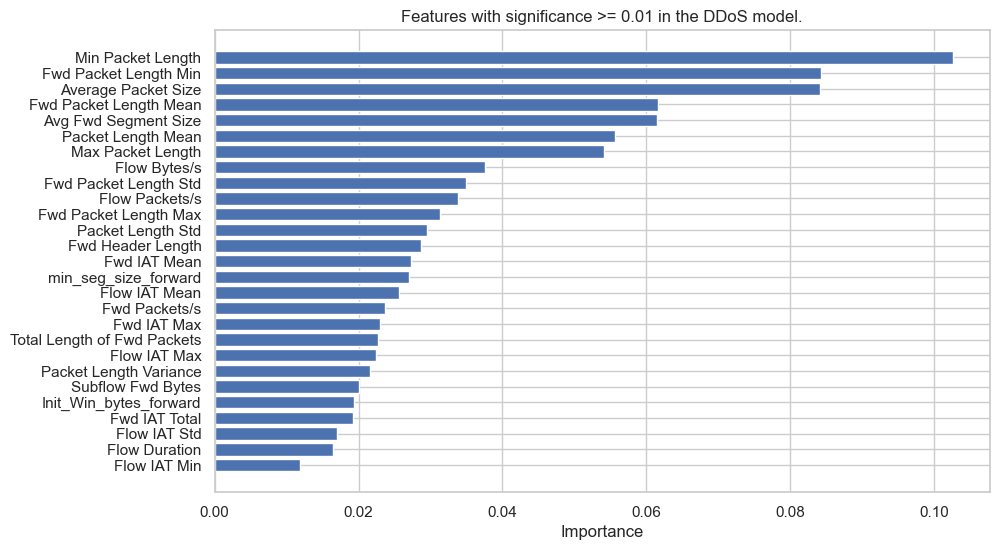

In [53]:
important_features_indices = extract_important_features(rf_model, trimmed_dataset)

In [54]:
new_rf_accuracy = accuracy_score(re_Y_test, re_rf_pred)

# Użycie 'macro' jako przykład
new_rf_f1 = f1_score(re_Y_test, re_rf_pred, average='macro')
new_rf_precision = precision_score(re_Y_test, re_rf_pred, average='macro')
new_rf_recall = recall_score(re_Y_test, re_rf_pred, average='macro')

visualizationMetrics(rf_accuracy, rf_f1, rf_precision, rf_recall)
print("------------ after trimming ------------")
visualizationMetrics(new_rf_accuracy, new_rf_f1, new_rf_precision, new_rf_recall)

      Metric     Value
0   Accuracy  0.979481
1   F1 Score  0.828156
2  Precision  0.806897
3     Recall  0.855477
------------ after trimming ------------
      Metric     Value
0   Accuracy  0.979260
1   F1 Score  0.827943
2  Precision  0.806299
3     Recall  0.855094


Analiza Wyników
- Accuracy:
Spadek z 0.974144 do 0.974014 jest minimalny i sugeruje, że model nadal dobrze klasyfikuje dane, mimo że nieco gorzej niż wcześniej.

- F1 Score:
Wzrost z 0.848583 do 0.850568 wskazuje na lepszą równowagę między precyzją a czułością (recall). Oznacza to, że model lepiej radzi sobie z identyfikowaniem pozytywnych przypadków (DDoS), co jest kluczowe w kontekście detekcji ataków.


- Precision:
Minimalny spadek z 0.830370 do 0.830247 sugeruje, że liczba fałszywych alarmów (false positives) pozostała na podobnym poziomie, co może być korzystne w kontekście detekcji ataków, gdzie fałszywe alarmy mogą prowadzić do niepotrzebnych działań.


- Recall:
Wzrost z 0.870465 do 0.875301 oznacza, że model lepiej identyfikuje rzeczywiste ataki DDoS, co jest kluczowe dla skuteczności systemu detekcji.

### II model - SVM

In [ ]:
# Ocena modelu
print("Macierz pomyłek:")
print(confusion_matrix(Y_test, y_pred))

print("\nRaport klasyfikacji:")
print(classification_report(Y_test, y_pred))

### Evaluate Logistic Regression

In [95]:
# lr_accuracy = accuracy_score(Y_test, lr_pred)
# lr_f1 = f1_score(Y_test, lr_pred)
# lr_precision = precision_score(Y_test, lr_pred)
# lr_recall = recall_score(Y_test, lr_pred)

In [97]:


# visualizationMetrics(lr_accuracy, lr_f1, lr_precision, lr_recall)

### Visualization

In [98]:
# plot_confusion_matrix(Y_test, lr_pred, ['Benign', 'DDoS'], "Logistic Regression Confusion Matrix")

###  Neural Network

In [99]:
# nn_model = MLPClassifier(hidden_layer_sizes=10, max_iter=10, random_state=42)
# nn_model.fit(X_train, Y_train)
# nn_pred = nn_model.predict(X_test)

### Evaluate Neural Network

In [100]:
# nn_accuracy = accuracy_score(Y_test, nn_pred)
# nn_f1 = f1_score(Y_test, nn_pred)
# nn_precision = precision_score(Y_test, nn_pred)
# nn_recall = recall_score(Y_test, nn_pred)

# visualizationMetrics(nn_accuracy, nn_f1, nn_precision, nn_recall)

### Visualization

In [101]:
# plot_confusion_matrix(Y_test, nn_pred, ['Benign', 'DDoS'], "Neural Network Confusion Matrix")

### Model Comparison

In [102]:

# rf_proba = rf_model.predict_proba(X_test)

# lr_proba = lr_model.predict_proba(X_test)

# nn_proba = nn_model.predict_proba(X_test)

### Prediction for ROC Curve

In [103]:
# rf_fp ,rf_tp, _ = roc_curve(Y_test, rf_proba[:, 1])
# rf_auc = auc(rf_fp, rf_tp)

# lr_fp ,lr_tp, _ = roc_curve(Y_test, lr_proba[:, 1])
# lr_auc = auc(lr_fp, lr_tp)

# nn_fp ,nn_tp, _ = roc_curve(Y_test, nn_proba[:, 1])
# nn_auc = auc(nn_fp, nn_tp)

# plt.figure(figsize=(8,6))
# plt.plot(rf_fp, rf_tp, label=f'Random Forest (AUC = {rf_auc:.2f})')
# plt.plot(lr_fp, lr_tp, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
# plt.plot(nn_fp, nn_tp, label=f'Neural Network (AUC = {nn_auc:.2f})')

# plt.plot([0,1], [0,1], linestyle='--', color='black', label=f'Random Classifier (AUC - 0.50')

# plt.xlabel('False positive')
# plt.ylabel('True positive')
# plt.title('Reciver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.grid()
# plt.show()